In [2]:
import pandas as  pd
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import sklearn
import seaborn as sns
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

---
## **Partie 1 et 2** ##
---

## ***Création du premier DataFrame*** ##

In [3]:
dfG = pd.read_csv("Data/GSM3533230_CGND-HRA-00013_counts.txt", sep="\t")
dfG.head()

,gene/TE,../../STAR_v252_mapping/CGND_12616/HRA-00013_PE.bam
0,A1BG,42
1,A1BG-AS1,149
2,A1CF,0
3,A2M,3327
4,A2M-AS1,101


In [4]:
path = "./Data" # the path of the data

pdList = [] # variable to temporary store all dataframes (one for each txt file)
# For all txt file
for fname in glob.glob(path+"/*.txt"):
    df = pd.read_table(fname) # put the file in a dataframe
    sample_name = re.search("GSM\d+", fname).group() # search the name of the sample in the file name
    df.rename(index= df["gene/TE"], inplace=True) # rename the index (=rows) using the column containing the gene name
    df.drop(columns=df.columns[0], axis=1, inplace=True) # drop the first column containing the gene name, no more need
    df.rename(columns={ df.columns[0]: sample_name }, inplace = True) # rename the column (there is only one column at this step) using the sample name
    pdList.append(df) # add the current dataframe in the list
data_matrix = pd.concat(pdList, 1) # concat all dataframe in 1 dataframe
data_matrix = data_matrix.transpose() # transpose the dataframe to get a more standard shape (samples x variables)

In [5]:
class MyDataFrame:
    
    def __init__(self, folder_path):
        self.__data_matrix = []  #initialise une liste vide pour stocker la matrice de données
    
    def get_data_matrix(self):
        return self.__data_matrix #retourne la matrice de données
    
    def set_data_matrix(self,dataFrame):
        self.__data_matrix = dataFrame #permet de modifier la matrice de données
        
    def get_describe(self):
        return self.__data_matrix.describe() #retourne une description de la matrice de données (moyenne, écart-type, etc.)
    


    def get_num_sample(self):
        return len(self.__data_matrix) #retourne le nombre d'échantillons dans la matrice de données

    def get_num_gene(self):
        return len(self.__data_matrix.columns) #retourne le nombre de gènes dans la matrice de données
    

    def get_sample_by_index(self, index):
        return self.__data_matrix.iloc[index] #retourne l'échantillon à l'indice donné
    

    def get_gene_by_index(self, index):
        return self.__data_matrix.iloc[:, index] #retourne le gène à l'indice donné

   
    def get_median(self, is_sample=True):
        median = dict()
        if is_sample:
            for col in self.__data_matrix.columns:
                median[col] = self.__data_matrix.loc[:, col].median()
        else:
            for idx, row in self.__data_matrix.iterrows():
                median[idx] = row.median()
        return median  #retourne un dictionnaire contenant la médiane de chaque gène ou chaque échantillon selon la valeur de is_sample


    
    def get_mean(self, is_sample=True):
        mean = dict()
        if is_sample:
            for col in self.__data_matrix.columns:
                mean[col] = self.__data_matrix.loc[:, col].mean()
        else:
            for idx, row in self.__data_matrix.iterrows():
                mean[idx] = row.mean() #retourne un dictionnaire contenant la moyenne de chaque gène ou chaque échantillon selon la valeur de is_sample
        return mean

    
    def get_std(self, is_sample=True):
        std = dict()
        if is_sample:
            for col in self.__data_matrix.columns:
                std[col] = self.__data_matrix.loc[:, col].std()
        else:
            for idx, row in self.__data_matrix.iterrows():
                std[idx] = row.std() #retourne un dictionnaire contenant l'écart type de chaque gène ou chaque échantillon selon la valeur de is_sample
        return std

   
    def get_min(self, is_sample=True):
        min = dict()
        if is_sample:
            for col in self.__data_matrix.columns:
                min[col] = self.__data_matrix.loc[:, col].min()
        else:
            for idx, row in self.__data_matrix.iterrows():
                min[idx] = row.min() #retourne un dictionnaire contenant le minimum de chaque gène ou chaque échantillon selon la valeur de is_sample
        return min

    
    def get_max(self, is_sample=True):
        max = dict()
        if is_sample:
            for col in self.__data_matrix.columns:
                max[col] = self.__data_matrix.loc[:, col].max()
        else:
            for idx, row in self.__data_matrix.iterrows():
                max[idx] = row.max() #retourne un dictionnaire contenant le maximum de chaque gène ou chaque échantillon selon la valeur de is_sample
        return max

    def coef_var(self):
        coef_var = dict()
        for col in self.__data_matrix.columns:
            coef_var[col] = self.__data_matrix.loc[:, col].std()/self.__data_matrix.loc[:, col].mean()
       
        return coef_var # calcule le coefficient de variation pour chaque colonne de la matrice de données

    def get_gene(self,index):
        i = 0
        for col in self.__data_matrix.columns:
            if i == index:
                return col
            i = i+1  # renvoie le nom de la colonne correspondant à l'indice donné en entrée
        

        
      
    def _index(self,value,string):
        x = []
        if string == "median":
            dic = self.get_median()
        if string == "max":
            dic = self.get_max()
        if string == "min":
            dic = self.get_min()
        if string == "std":
            dic = self.get_std()
        if string == "mean":
            dic = self.get_mean()
        if string=="coef_var":
            dic = self.coef_var()
       
            
        key_list = list(dic.keys())

        for i in range(len(dic)):
            if dic[key_list[i]] >= value :
                x.append(i)
        return x   # renvoie une liste d'indices de colonnes pour lesquelles la valeur correspondant au string donné est supérieure ou égale à la valeur donnée en entrée

    def _indexA(self,value,string):
        x = []
        if string == "median":
            dic = self.get_median()
        if string == "max":
            dic = self.get_max()
        if string == "min":
            dic = self.get_min()
        if string == "std":
            dic = self.get_std()
        if string == "mean":
            dic = self.get_mean()
        if string=="coef_var":
            dic = self.coef_var()
       
            
        key_list = list(dic.keys())

        for i in range(len(dic)):
            if dic[key_list[i]] <= value :
                x.append(i)
        return x   # renvoie une liste d'indices de colonnes pour lesquelles la valeur correspondant au string donné est inférieure ou égale à la valeur donnée en entrée

            
   


    

        
    def plot_all_(self,is_sample = True):
        
        plt.figure(figsize=(12, 10))
        if is_sample:
            t = True
        else :
            t = False
        
        # Plot median
        gene1 = self.get_median(t)
        z1 = gene1.values()
        plt.subplot(3, 2, 1)
        plt.xlabel('Gene')
        plt.ylabel('Median')
        plt.title('Median expression level')
        plt.plot(z1, color='blue')
        
        # Plot mean
        gene2 = self.get_mean(t)
        z2 = gene2.values()
        plt.subplot(3, 2, 2)
        plt.xlabel('Gene')
        plt.ylabel('Mean')
        plt.title('Mean expression level ')
        plt.plot(z2, color='orange')
        
        # Plot standard deviation
        gene3 = self.get_std(t)
        z3 = gene3.values()
        plt.subplot(3, 2, 3)
        plt.xlabel('Gene')
        plt.ylabel('Std')
        plt.title('Standard deviation of expression level')
        plt.plot(z3, color='green')
        
        # Plot minimum
        gene4 = self.get_min(t)
        z4 = gene4.values()
        plt.subplot(3, 2, 4)
        plt.xlabel('Gene')
        plt.ylabel('Min')
        plt.title('Minimum expression level ')
        plt.plot(z4, color='red')
        
        # Plot maximum
        gene5 = self.get_max(t)
        z5 = gene5.values()
        plt.subplot(3, 2, 5)
        plt.xlabel('Gene')
        plt.ylabel('Max')
        plt.title('Maximum expression level ')
        plt.plot(z5, color='purple')

        plt.tight_layout()
        plt.show()

    
        
        
            
        
        
    



In [6]:
dataV1 = MyDataFrame("Data")
dataV1.get_data_matrix()
dataV1.set_data_matrix(data_matrix)
dataV1.get_data_matrix()



,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533382,42,189,0,4052,92,201,1,8,76,1,...,1023,2363,2137,1265,100,607,140,551,2269,2233
GSM3533252,37,110,0,4660,102,64,7,1,68,0,...,880,2077,1908,1072,119,478,129,525,1821,1921
GSM3533337,31,110,0,1484,84,60,1,1,12,0,...,656,1357,1345,749,61,341,102,346,1122,1437
GSM3533314,14,41,0,2185,105,198,4,0,24,0,...,958,2017,1817,1087,99,527,145,446,1522,1757
GSM3533391,37,118,0,1245,104,168,1,1,21,1,...,847,1822,1625,903,96,472,120,415,1556,1768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533291,29,142,0,1429,102,115,2,4,14,1,...,671,1526,1319,735,85,394,92,330,1279,1408
GSM3533349,31,142,0,1526,108,122,2,1,139,0,...,758,1724,1575,866,76,427,122,430,1478,1660
GSM3533339,39,95,0,1223,74,89,1,3,39,0,...,687,1424,1340,693,101,354,83,300,1145,1390
GSM3533399,46,179,0,2899,89,109,1,6,46,1,...,796,1694,1488,869,89,469,99,442,1684,1836


No handles with labels found to put in legend.


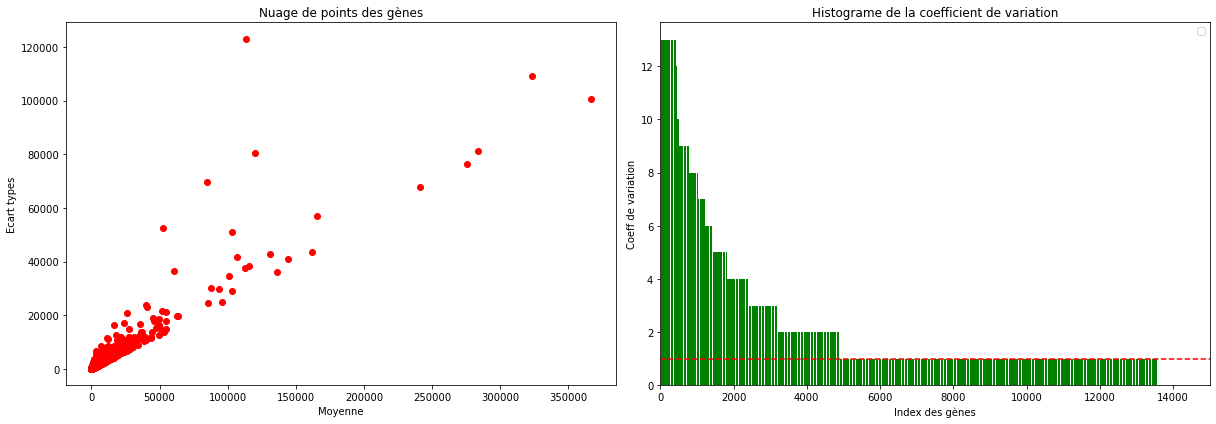

In [7]:
plt.figure(figsize=(17, 6))

# Gene plot
plt.subplot(1, 2, 1)
plt.scatter(x=data_matrix.mean().values, y=data_matrix.std().values, c="red")
plt.title("Nuage de points des gènes")
plt.xlabel("Moyenne")
plt.ylabel("Ecart types")



# CV histogram plot
cv = data_matrix.std() / data_matrix.mean()
cv = cv.round().sort_values(ascending=False)
labels = range(len(cv.keys()))

plt.subplot(1, 2, 2)
plt.bar(x=labels, height=cv.values, color="green")
plt.axhline(y=1, color='red', linestyle='--')
plt.title("Histograme de la coefficient de variation")
plt.xlabel("Index des gènes")
plt.ylabel("Coeff de variation")
plt.xlim(0, 15000)
plt.legend()

plt.tight_layout()
plt.show()

## ***Création du second DataFrame*** ##
On va diminuer le DataFrame en supprimant les valeures qui semblent aberantes 

In [8]:
coef_val_dic1 = dataV1._index(30000,"std")  # on prend l'id des genes qui ont un écart type plus grand que 30000 
coef_val_dic2 = dataV1._index(85000,"mean") # on prend l'id des genes qui ont un écart type plus grand que 85000

coef_val_dic = coef_val_dic1.copy() 

for item in coef_val_dic2:
    if item not in coef_val_dic:
        coef_val_dic.append(item)
data2b = dataV1.get_data_matrix()
data2b = data2b.drop(data2b.columns[coef_val_dic],axis=1)
dataV2 = MyDataFrame("Data")
dataV2.set_data_matrix(data2b)  # on crée un nouveau DataFrame sans ces valeurs 

In [9]:
for i in coef_val_dic:
    if dataV1.get_gene(i) == dataV2.get_gene(i):
        print("!!!!!!!")  # on teste si ces valeurs ne sont pas dans le nouveau dataframe


No handles with labels found to put in legend.


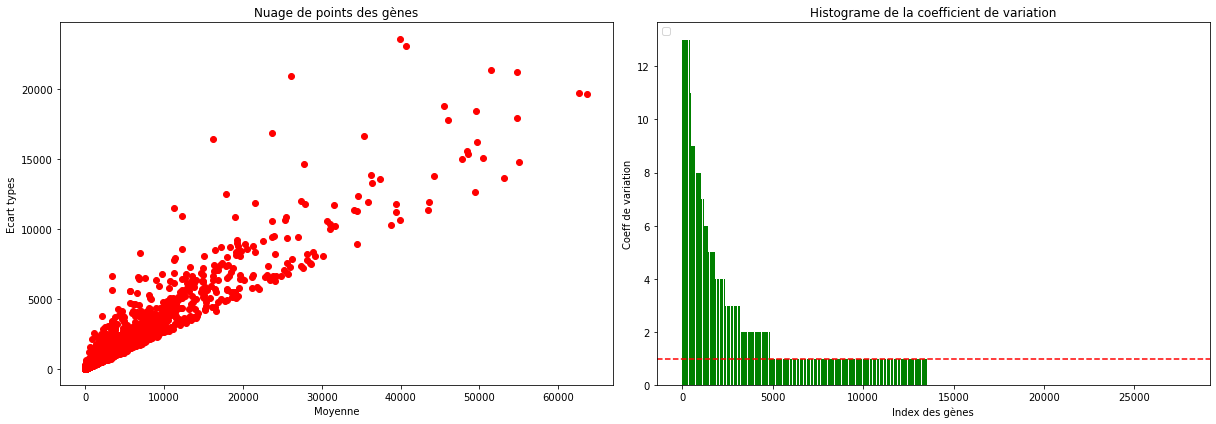

In [10]:
plt.figure(figsize=(17, 6))

# Gene plot
plt.subplot(1, 2, 1)
plt.scatter(x=data2b.mean().values, y=data2b.std().values, c="red")
plt.title("Nuage de points des gènes")
plt.xlabel("Moyenne")
plt.ylabel("Ecart types")


# CV histogram plot
cv = data2b.std() / data2b.mean()
cv = cv.round().sort_values(ascending=False)
labels = range(len(cv.keys()))

plt.subplot(1, 2, 2)
plt.bar(x=labels, height=cv.values, color="green")
plt.axhline(y=1, color='red', linestyle='--')
plt.title("Histograme de la coefficient de variation")
plt.xlabel("Index des gènes")
plt.ylabel("Coeff de variation")
plt.legend()

plt.tight_layout()
plt.show()





## ***Création du  DataFrame V5*** ##
On voit qu'il y a encore des valeures qui semblent trop grande.

In [11]:
coef_val_dicD1 = dataV2._index(1500,"std")
coef_val_dicD2 = dataV2._index(4000,"mean")
coef_val_dicD = coef_val_dicD1.copy()  # Copie la première liste pour ne pas la modifier directement

for item in coef_val_dicD2:
    if item not in coef_val_dicD:
        coef_val_dicD.append(item)
data5b = dataV2.get_data_matrix()
data5b = data5b.drop(data5b.columns[coef_val_dicD],axis=1)
dataV5 = MyDataFrame("Data")
dataV5.set_data_matrix(data5b)

No handles with labels found to put in legend.


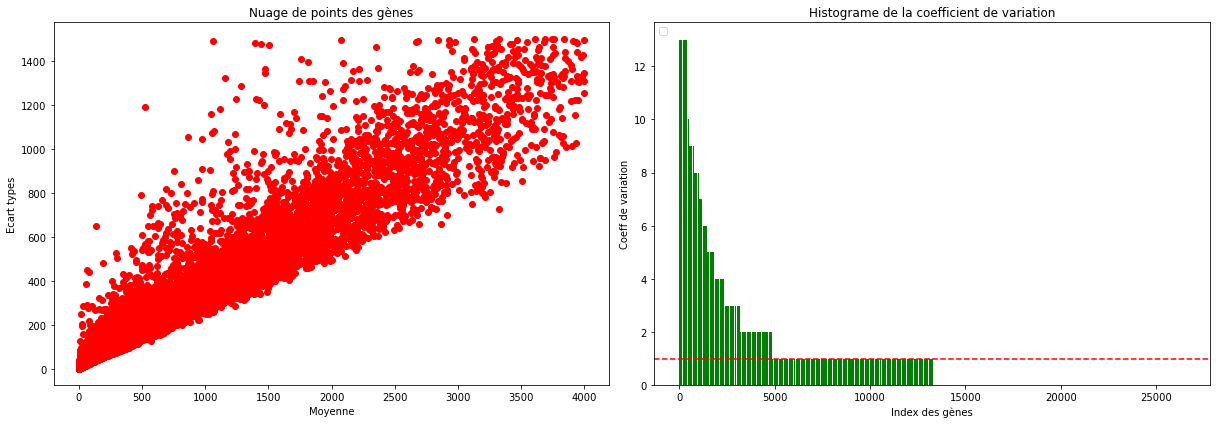

In [12]:
plt.figure(figsize=(17, 6))

# Gene plot
plt.subplot(1, 2, 1)
plt.scatter(x=data5b.mean().values, y=data5b.std().values, c="red")
plt.title("Nuage de points des gènes")
plt.xlabel("Moyenne")
plt.ylabel("Ecart types")


# CV histogram plot
cv = data5b.std() / data5b.mean()
cv = cv.round().sort_values(ascending=False)
labels = range(len(cv.keys()))

plt.subplot(1, 2, 2)
plt.bar(x=labels, height=cv.values, color="green")
plt.axhline(y=1, color='red', linestyle='--')
plt.title("Histograme de la coefficient de variation")
plt.xlabel("Index des gènes")
plt.ylabel("Coeff de variation")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
print(dataV1.get_num_gene())
print(dataV2.get_num_gene())
print(dataV5.get_num_gene())

28953
28928
27633


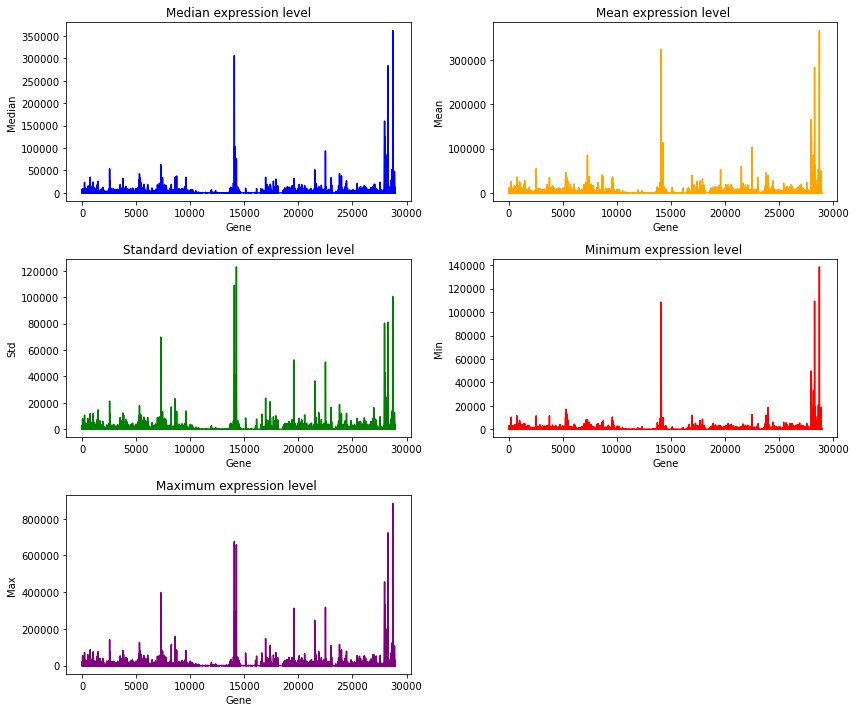

In [14]:
dataV1.plot_all_()

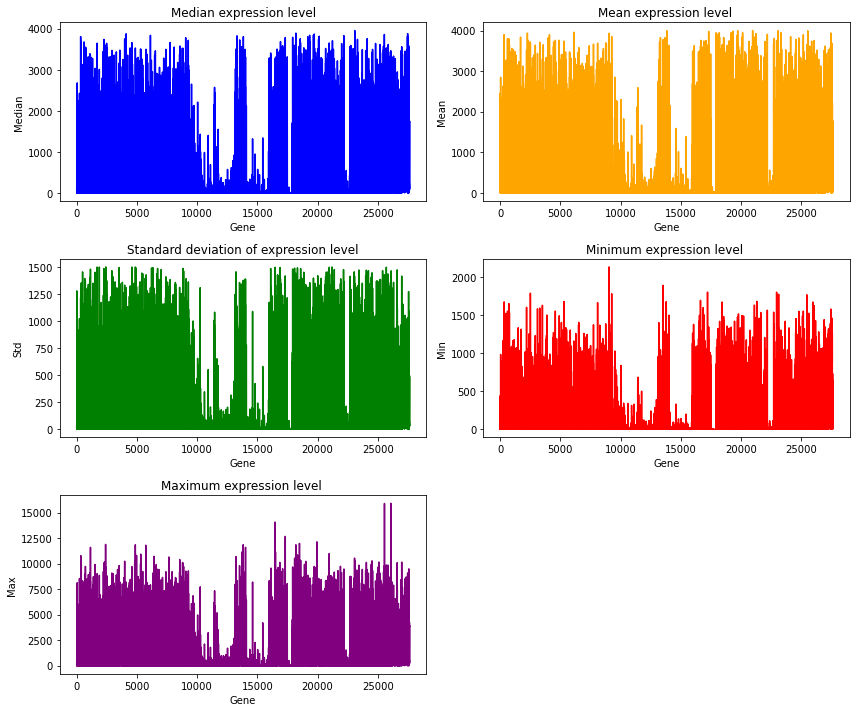

In [15]:
dataV5.plot_all_()

Test

In [16]:
dataV1.get_median()['A1BG'] == data_matrix['A1BG'].median()
dataV1.get_mean()['A2ML1'] == data_matrix['A2ML1'].mean()
dataV1.get_std()['A1BG'] == data_matrix['A1BG'].std()
dataV1.get_max()['A2ML1'] == data_matrix['A2ML1'].max()
dataV1.get_min()['A1BG'] == data_matrix['A1BG'].min()

True

## ***Lecture du fichier XML*** ##


In [17]:
# LECTURE FICHIER XML
url = '{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}'
tree = ET.parse('Data/GSE124439_family.xml')
root = tree.getroot()
#samples = root.findall(url+"Sample")
#print(samples)

data_list = []

# Loop to loop through samples and extract other annotations
for sample in root.findall(url+'Sample'): 
    #Sample ID retrieval
    #print(sample)
    sample_id = sample.get('iid')
    
    # Recovery of annotations
    annotations = {}
    for i in sample.findall(url+'Channel'):
        #print(i)
        for charac in i.findall(url+'Characteristics'):
            if charac.get('tag') in ['cns subregion', 'subject id', 'sample group']:
                annotations[charac.get('tag')] = charac.text.strip()    
    # Add data to list
    data = {'sample_id': sample_id, **annotations}
    data_list.append(data)
#print(ET.tostring(root, encoding='unicode'))    
# Creating the DataFrame from the data

dff = pd.DataFrame(data_list)  
dff

,sample_id,cns subregion,subject id,sample group
0,GSM3533230,Frontal Cortex,NEUEL133AK6,ALS Spectrum MND
1,GSM3533231,Frontal Cortex,NEUYV496XLP,ALS Spectrum MND
2,GSM3533232,Frontal Cortex,NEUZU200WEQ,ALS Spectrum MND
3,GSM3533233,Frontal Cortex,NEUME287RK2,ALS Spectrum MND
4,GSM3533234,Frontal Cortex,NEUEC006FND,ALS Spectrum MND
...,...,...,...,...
171,GSM3533401,Frontal Cortex,NEUMY028JH4,ALS Spectrum MND
172,GSM3533402,Frontal Cortex,NEUXR145UBL,ALS Spectrum MND
173,GSM3533403,Frontal Cortex,NEUKN209FNW,ALS Spectrum MND
174,GSM3533404,Frontal Cortex,NEUUF289NRL,ALS Spectrum MND


In [18]:
class MyDataFrame2:
    
    def __init__(self, folder_path):
        self.__data_matrix = []  # Initialisation de l'attribut __data_matrix à une liste vide
    
    def get_data_matrix(self):
        return self.__data_matrix  # Renvoie l'attribut __data_matrix
    
    def set_data_matrix(self,dataFrame):
        self.__data_matrix = dataFrame # Met à jour l'attribut __data_matrix avec le DataFrame passé en paramètre

    # Cette méthode retourne 1 si le "sample group" de la ligne correspondant à l'index contient "ALS", 2 si
    # il contient "Other" et 0 sinon.
    
    def is_positive(self,index):
        if "ALS" in self.get_data_matrix().loc[index, "sample group"]:
            return 1
        if "Other" in self.get_data_matrix().loc[index,"sample group"]:
            return 2
        else:
            return 0



    # Cette méthode retourne 1 si la valeur de "diagnosis" de la ligne correspondant à l'index contient "sALS"
    # et 0 sinon.   
    def is_positive2(self,index):
        if "sALS" in self.get_data_matrix().loc[index, "diagnosis"]:
            return 1
        else:
            return 0
            
    # Cette méthode retourne 1 si la valeur de "cns subregion" de la ligne correspondant à l'index contient
    # "Frontal Cortex" et 0 si elle contient "Motor Cortex". Elle ne retourne rien sinon.
    def cns_sub(self,index):
        if "Frontal Cortex" in self.get_data_matrix().loc[index,"cns subregion"]:
            return 1
        if "Motor Cortex" in self.get_data_matrix().loc[index,"cns subregion"]:
            return 0
        
        

In [19]:
dataZ = MyDataFrame2("Data1")
dataZ.get_data_matrix()
dataZ.set_data_matrix(dff)
dataZ.get_data_matrix()

,sample_id,cns subregion,subject id,sample group
0,GSM3533230,Frontal Cortex,NEUEL133AK6,ALS Spectrum MND
1,GSM3533231,Frontal Cortex,NEUYV496XLP,ALS Spectrum MND
2,GSM3533232,Frontal Cortex,NEUZU200WEQ,ALS Spectrum MND
3,GSM3533233,Frontal Cortex,NEUME287RK2,ALS Spectrum MND
4,GSM3533234,Frontal Cortex,NEUEC006FND,ALS Spectrum MND
...,...,...,...,...
171,GSM3533401,Frontal Cortex,NEUMY028JH4,ALS Spectrum MND
172,GSM3533402,Frontal Cortex,NEUXR145UBL,ALS Spectrum MND
173,GSM3533403,Frontal Cortex,NEUKN209FNW,ALS Spectrum MND
174,GSM3533404,Frontal Cortex,NEUUF289NRL,ALS Spectrum MND


Test

In [20]:
print(dataZ.is_positive(150) == 2)
print(dataZ.is_positive(1) == 1)
print(dataZ.cns_sub(0) == 1)

True
True
True


## ***Création de nouveaux DataFrames*** ##

On va crée deux autres dataFrames
    

In [21]:
l = []
ll = []
for i in range(175):
    if dataZ.cns_sub(i) == 1:
        l.append(dataV1.get_data_matrix().index[i])
    else :
        ll.append(dataV1.get_data_matrix().index[i])


In [22]:

data5 = dataV5.get_data_matrix().drop(index = l)
data6 = dataV5.get_data_matrix().drop(index = ll)

In [23]:

dataV8 = MyDataFrame("Data")
dataV8.set_data_matrix(data5)
# dataV8 correspond aux données sur les personnes qui ont comme cns subregion Frontal Cortex
dataV9 = MyDataFrame("Data")
dataV9.set_data_matrix(data6)
 # dataV9 correspond aux données sur les personnes qui ont comme cns subregion Motor Cortex

---
## **Partie 3** ##
---

## ***PCA*** ##


In [24]:
# on crée une instance de l'objet StandardScaler pour centrer et réduire les données
scaler = StandardScaler()
# on transforme les données originales en données centrées et réduites
X_scaled = scaler.fit_transform(dataV8.get_data_matrix())

# on crée une instance de l'objet PCA en spécifiant le nombre de composantes principales souhaité
pca = PCA(n_components=96)
# on applique l'analyse en composantes principales aux données centrées et réduites
X_pca = pca.fit_transform(X_scaled)

variance_cumulee = sum(pca.explained_variance_ratio_)*100
print(variance_cumulee)


99.99999999999999


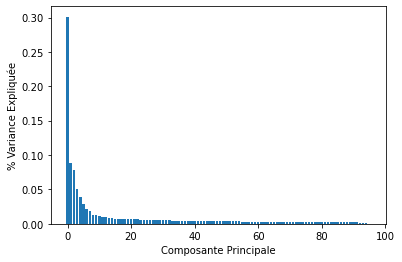

In [25]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Composante Principale')
plt.ylabel('% Variance Expliquée')
plt.show()



In [26]:

X_scaled = scaler.fit_transform(dataV8.get_data_matrix())
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

variance_cumulee = sum(pca.explained_variance_ratio_)*100
print(variance_cumulee)

79.13039123141338


In [27]:
def plot_pca(X_pca, data2, i, j):
    pc1 = X_pca[:,i-1]
    pc2 = X_pca[:,j-1]

    # appliquer la fonction is_positive() à chaque point et définir la couleur correspondante
    colors = np.array(['red', 'green','blue'])
    y = np.array([data2.is_positive(i) for i in np.arange(len(pc1))])
    colors = colors[y]

    # définir les étiquettes de légende pour chaque couleur
    labels = [('red', 'Sain'), ('green', 'malade'), ('blue', 'autre')]

    # créer une liste de poignées (handles) pour la légende
    handles = [plt.Line2D([], [], marker='o', linestyle='None', color=color, label=label) for color, label in labels]

    # tracer le graphique en deux dimensions avec les coordonnées des échantillons dans les deux premiers PC
    fig, ax = plt.subplots()
    ax.scatter(pc1, pc2, c=colors)
    ax.legend(handles=handles)
    ax.set_xlabel('PC{}'.format(i))
    ax.set_ylabel('PC{}'.format(j))
    plt.show()


dataframe 8 (region Frontal Cortex)

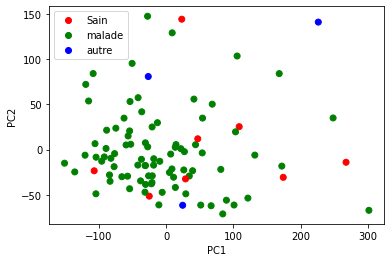

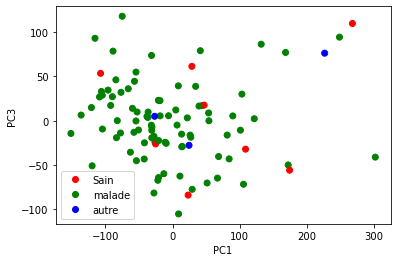

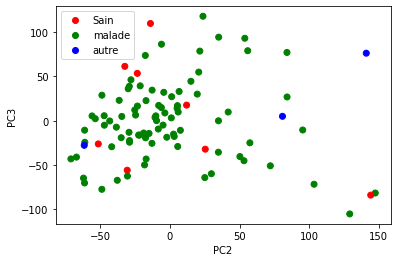

In [28]:
plot_pca(X_pca,dataZ,1,2)
plot_pca(X_pca,dataZ,1,3)
plot_pca(X_pca,dataZ,2,3)


In [29]:
X_scaled = scaler.fit_transform(dataV9.get_data_matrix())
pca = PCA(n_components=29)
X_pca = pca.fit_transform(X_scaled)

variance_cumulee = sum(pca.explained_variance_ratio_)*100
print(variance_cumulee)

79.7033117406377


dataframe 9 (region Motor Cortex)

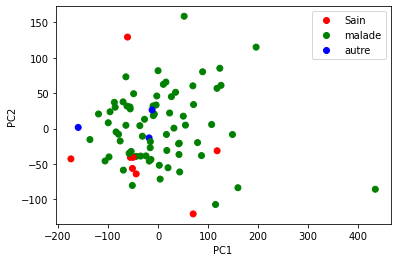

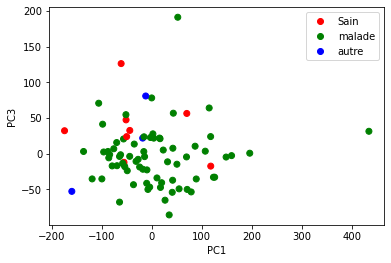

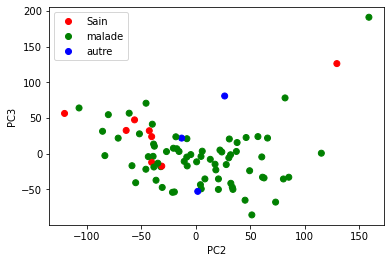

In [30]:
plot_pca(X_pca,dataZ,1,2)
plot_pca(X_pca,dataZ,1,3)
plot_pca(X_pca,dataZ,2,3)


In [31]:
X_scaled = scaler.fit_transform(dataV5.get_data_matrix())
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_scaled)

variance_cumulee = sum(pca.explained_variance_ratio_)*100
print(variance_cumulee)

81.38109239617505


dataframe5

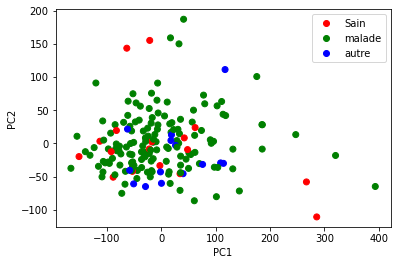

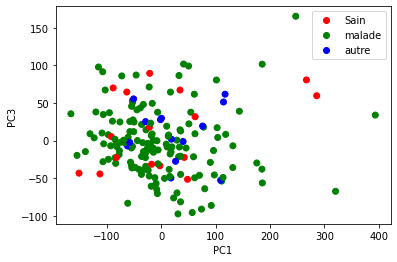

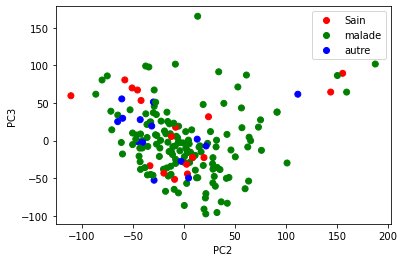

In [32]:
plot_pca(X_pca,dataZ,1,2)
plot_pca(X_pca,dataZ,1,3)
plot_pca(X_pca,dataZ,2,3)


TEST

In [33]:
pc1 = X_pca[:,4]
y = np.array([dataZ.is_positive(i) for i in np.arange(len(pc1))])

In [34]:
#####test################
for i in range (len(pc1)):
    if y[i]!=dataZ.is_positive(i):
        print("!!!!!!!!")

---
## **Partie 5** ##
---

## ***pvalues et volcano plot*** ##


In [35]:
als_index = dataZ.get_data_matrix()['sample group'] == "ALS Spectrum MND" 
ctrl_index = dataZ.get_data_matrix()['sample group'] == "Non-Neurological Control"

In [36]:
pvalues = dataV5.get_data_matrix().apply(lambda x: ttest_ind(x[als_index.values], x[ctrl_index.values]).pvalue)

In [37]:
pvalues

A1BG                      0.291018
A1BG-AS1                  0.426198
A1CF                      0.180929
A2M                       0.231381
A2M-AS1                   0.906208
                            ...   
X8_LINE:CR1:LINE          0.797876
X9_LINE:L1:LINE           0.975164
Zaphod2:hAT-Tip100:DNA    0.949136
Zaphod3:hAT-Tip100:DNA    0.713074
Zaphod:hAT-Tip100:DNA     0.710740
Length: 27633, dtype: float64

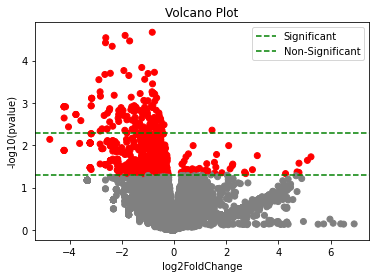

In [38]:
# Définir les axes x et y
epsilon = 0.01 # small constant to avoid division by zero
x = dataV5.get_data_matrix().apply(lambda x: np.log2(x[als_index.values].mean() / (x[ctrl_index.values].mean() + epsilon)))

y = -1 * np.log10(pvalues)

# Définir la couleur et la taille des points
color = np.where(pvalues<0.05, 'red', 'gray')

# Tracer le graphique
plt.scatter(x, y, c=color)
plt.axhline(y=1.3, color='green', linestyle='--')
plt.axhline(y=2.3, color='green', linestyle='--')

# Personnaliser le graphique
plt.xlabel('log2FoldChange')
plt.ylabel('-log10(pvalue)')
plt.title('Volcano Plot')
plt.legend(['Significant', 'Non-Significant'])

# Afficher le graphique
plt.show()

On va extraire les gènes qui se trouvent entre les bornes vertes.

In [39]:
def compute_log10_p_values(p_values):
    log10_p_values = []
    for p in p_values:
        log10_p_values.append(-np.log10(p))
    return log10_p_values



In [40]:
# Liste des indices des p_values ayant un -log10 entre 1.3 et 2.3
indices = []
log10_p_values = compute_log10_p_values(pvalues)
for i, val in enumerate(log10_p_values):
    if 1.3 <= val <= 2.3:
        indices.append(i)
        
print(indices)

[8, 45, 46, 49, 168, 197, 199, 202, 217, 262, 290, 368, 474, 545, 547, 548, 560, 562, 576, 582, 605, 636, 692, 900, 902, 906, 907, 920, 1005, 1030, 1102, 1151, 1209, 1212, 1216, 1317, 1373, 1398, 1432, 1452, 1509, 1584, 1660, 1667, 1668, 1671, 1728, 1757, 1790, 1819, 1838, 1895, 1907, 1949, 1962, 1964, 2141, 2295, 2304, 2372, 2463, 2533, 2734, 2757, 2766, 2804, 2813, 2834, 2839, 2840, 2883, 2976, 2987, 3011, 3072, 3082, 3100, 3236, 3237, 3273, 3344, 3352, 3406, 3442, 3474, 3518, 3590, 3653, 3666, 3704, 3765, 3773, 3842, 3858, 3866, 3943, 4004, 4036, 4229, 4258, 4259, 4279, 4299, 4313, 4326, 4336, 4473, 4519, 4524, 4573, 4753, 4894, 4912, 4918, 5131, 5162, 5226, 5235, 5243, 5360, 5387, 5388, 5391, 5410, 5450, 5467, 5477, 5499, 5524, 5527, 5584, 5586, 5605, 5609, 5681, 5704, 5745, 5837, 5843, 5870, 5892, 5920, 5937, 5960, 5970, 5974, 5984, 5985, 5987, 6022, 6032, 6128, 6156, 6158, 6221, 6228, 6230, 6263, 6270, 6326, 6418, 6427, 6433, 6439, 6450, 6487, 6492, 6519, 6540, 6599, 6611, 6614, 

In [41]:
datab9 = dataV5.get_data_matrix().iloc[:, indices]
datab9


,A4GALT,ABCA6,ABCA7,ABCB1,ACOT12,ACSL5,ACSM2A,ACSM4,ACTL10,ADAM15,...,WDR90,WDR97,XRCC6P5,ZNF114,ZNF295-AS1,ZP1,GSATII:centr:Satellite,HERV-Fc1_LTR3:ERV1:LTR,L1P4b:L1:LINE,LTR39-int:ERV1:LTR
GSM3533382,76,872,750,875,7,291,0,0,0,778,...,316,138,1,22,2,3,786,0,200,76
GSM3533252,68,696,355,695,3,282,0,0,2,465,...,135,97,1,10,4,0,315,0,234,66
GSM3533337,12,365,101,215,9,57,0,0,2,338,...,58,18,1,43,0,1,243,4,117,36
GSM3533314,24,588,154,254,4,108,0,0,1,210,...,37,18,0,25,3,0,260,1,110,54
GSM3533391,21,537,215,269,2,111,0,0,2,264,...,104,28,1,14,2,1,411,0,202,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533291,14,582,279,205,5,48,0,0,2,387,...,145,78,1,24,1,3,496,0,126,31
GSM3533349,139,485,299,218,4,227,0,0,4,339,...,124,56,0,23,4,1,318,1,185,46
GSM3533339,39,1287,135,184,5,80,0,0,2,348,...,61,34,1,23,2,0,215,0,79,32
GSM3533399,46,556,379,356,10,207,0,0,0,410,...,157,70,2,10,4,1,302,0,140,53


In [42]:
dataV9 = MyDataFrame("Data")
dataV9.set_data_matrix(datab9)


---
## **Partie 6** ##
---

In [43]:
# on normalise nos données
x = scaler.fit_transform(dataV1.get_data_matrix())

# on cree notre ensemble de labels (0 pour les controles, 1 pour les malades)
y = [0] * 176

for i in range(len(y)):
    if dataZ.is_positive(i):
      y[i] = 1
print(y)
print(len(y))


[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
176


***LOGISTIC REGRESSION AVEC CROSS VALIDATION***

In [44]:
# 1.30 minutes d'execution
elasticNet = LogisticRegressionCV(penalty='elasticnet', cv= 3, solver='saga', l1_ratios=[0.25,0.5,0.75], Cs=[0.1,0.5], scoring= 'accuracy').fit(x, y)

/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassi

In [45]:
model_prediction = elasticNet.predict(x)
accuracy_train_dataset = sklearn.metrics.accuracy_score(y, model_prediction)
accuracy_train_dataset

0.9545454545454546

***ON CREE NOTRE DATAFRAME POUR LE DATASET DE TEST***

In [46]:
path = "./Data_test"
pdList = [] 

for fname in glob.glob(path+"/*.txt"):
    df = pd.read_table(fname) 
    sample_name = re.search("GSM\d+", fname).group() 
    df.rename(index= df["gene/TE"], inplace=True) 
    df.drop(columns=df.columns[0], axis=1, inplace=True) 
    df.rename(columns={ df.columns[0]: sample_name }, inplace = True) 
    pdList.append(df) 
datatest_matrix = pd.concat(pdList, 1) 
datatest_matrix = datatest_matrix.transpose()

In [47]:
datatest = MyDataFrame("Data_set")
datatest.set_data_matrix(datatest_matrix)
datatest.get_data_matrix().head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3477246,28,76,0,3462,98,141,4,2,15,1,...,508,1118,992,520,42,276,50,294,1290,1593
GSM3477226,60,209,0,6811,136,250,1,1,54,1,...,708,1697,1461,893,53,458,156,461,1773,1938
GSM3477224,82,277,0,7690,187,209,4,6,65,1,...,696,1633,1520,956,70,480,100,491,2079,2170
GSM3477244,96,224,3,8890,166,269,5,0,47,1,...,973,2533,2328,1350,84,682,175,691,2609,3090
GSM3477220,44,149,1,5266,125,186,2,0,138,2,...,690,1708,1492,864,68,394,83,354,1685,2210


In [48]:
# On normalise les données
x_test = scaler.fit_transform(datatest.get_data_matrix())

In [49]:
# LECTURE FICHIER XML TEST
url = '{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}'
tree = ET.parse('Data_test/GSE122649_family.xml')
root = tree.getroot()
#samples = root.findall(url+"Sample")
#print(samples)
data_list = []
for sample in root.findall(url+'Sample'): 
    sample_id = sample.get('iid')
    annotations = {}
    for i in sample.findall(url+'Channel'):
        #print(i)
        for charac in i.findall(url+'Characteristics'):
            if charac.get('tag') in ['tissue', 'subject id', 'diagnosis']:
                annotations[charac.get('tag')] = charac.text.strip()    

    data = {'sample_id': sample_id, **annotations}
    data_list.append(data)
df1 = pd.DataFrame(data_list)  

In [50]:
datatest2 = MyDataFrame2("Data_test")
datatest2.get_data_matrix()
datatest2.set_data_matrix(df1)
datatest2.get_data_matrix()

,sample_id,tissue,subject id,diagnosis
0,GSM3477217,motor cortex,JR9,sALS
1,GSM3477218,motor cortex,JR9,sALS
2,GSM3477219,motor cortex,JR48,sALS
3,GSM3477220,motor cortex,JR48,sALS
4,GSM3477221,motor cortex,JR29,sALS
5,GSM3477222,motor cortex,JR29,sALS
6,GSM3477223,motor cortex,JR30,sALS/FTD
7,GSM3477224,motor cortex,JR30,sALS/FTD
8,GSM3477225,motor cortex,JR33,sALS
9,GSM3477226,motor cortex,JR33,sALS


In [51]:
print("x shape:", x.shape)
print("x_test shape:", x_test.shape)

x shape: (176, 28953)
x_test shape: (38, 28952)


***ON REMARQUE UNE DIFFERENCE (DE 1) ENTRE LES 2 DATASETS***
  
*On cherche donc a armoniser nos 2 datasets*

In [52]:
# difference de colonnes entre les 2 dataframes (dataV1 et datatest)
diff1 = datatest.get_data_matrix().columns.difference(dataV1.get_data_matrix().columns)
diff2 = dataV1.get_data_matrix().columns.difference(datatest.get_data_matrix().columns)


In [53]:
d1 = dataV1.get_data_matrix().drop(diff2, axis=1)
dt = datatest.get_data_matrix().drop(diff1, axis=1)
X_train = scaler.fit_transform(d1)
X_test = scaler.fit_transform(dt)
print(X_train.shape)
print(X_test.shape)

(176, 28926)
(38, 28926)


In [54]:
y_train = y

In [55]:
# WARNINGS normal car ne converge pas mais pas de soucis 
elasticNet = LogisticRegressionCV(penalty='elasticnet', cv= 3, solver='saga', l1_ratios=[0.25,0.5,0.75], Cs=[0.1,0.5], scoring= 'accuracy').fit(X_train, y_train)

/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassi

In [56]:
# Prédiction sur le jeu de test
model_prediction = elasticNet.predict(X_train)
accuracy_train_dataset = sklearn.metrics.accuracy_score(y_train, model_prediction)

In [57]:
model_prediction

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
# accuracy sur le jeu d'entrainement (train)
accuracy_train_dataset

0.9545454545454546

In [59]:
prediction_test = elasticNet.predict(X_test)
prediction_test

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [60]:
y_test = [0] * 38
for i in range(len(y_test)):
    if datatest2.is_positive2(i):
      y_test[i] = 1
print(y_test)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [61]:
accuracy_test_dataset = sklearn.metrics.accuracy_score(y_test, prediction_test)
print("Accuracy du modele sur les données de test : {:.3f}%".format(accuracy_test_dataset * 100))

Accuracy du modele sur les données de test : 65.789%


---

#### ***ON EFFECTUE A NOUVEAU NOS PREDICTIONS SUR LE DATAFRAME DATAV9***

##### *Version avec un nombre de gênes réduit car selectionnés dans la **Partie 5***

In [62]:
x9 = scaler.fit_transform(dataV9.get_data_matrix())
y9 = [0] * 176

for i in range(len(y9)):
    if dataZ.is_positive(i):
      y9[i] = 1
print(y9)
print(len(y9))


[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
176


In [63]:
elasticNet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5).fit(x9, y9)
model_prediction = elasticNet.predict(x9)
accuracy_train_dataset = sklearn.metrics.accuracy_score(y9, model_prediction)
accuracy_train_dataset

/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1.0

In [64]:
x_test = scaler.fit_transform(datatest.get_data_matrix())
print("x shape:", x9.shape)
print("x_test shape:", x_test.shape)

x shape: (176, 622)
x_test shape: (38, 28952)


In [65]:
common_columns = datatest.get_data_matrix().columns.intersection(dataV9.get_data_matrix().columns)

# on conserve uniquement les colonnes communes dans les 2 dataframes
common1 = datatest.get_data_matrix()[common_columns]
common2 = dataV9.get_data_matrix()[common_columns]
print(common1.shape)
print(common2.shape)

(38, 620)
(176, 620)


In [66]:
d9 = common2
dt9 = common1
X_train9 = scaler.fit_transform(d9)
X_test9 = scaler.fit_transform(dt9)
X_train9.shape
X_test9.shape

(38, 620)

In [67]:
y_train9 = y9

In [68]:
# WARNINGS normalement pas de soucis
elasticNet = LogisticRegressionCV(penalty='elasticnet', cv= 3, solver='saga', l1_ratios=[0.25,0.1,0.15], Cs=[0.15,0.13,0.1], scoring= 'accuracy').fit(X_train9, y_train9)


/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomassi

In [69]:
model_prediction = elasticNet.predict(X_train9)
accuracy_train_dataset = sklearn.metrics.accuracy_score(y_train9, model_prediction)
print("Accuracy du modele sur les données d'entrainement :",accuracy_train_dataset*100,'%')

Accuracy du modele sur les données d'entrainement : 100.0 %


***OVERFITTING peut-être ?***

In [70]:
prediction_test = elasticNet.predict(X_test9)

In [71]:
y_test9 = [0] * 38
for i in range(len(y_test9)):
    if datatest2.is_positive2(i):
      y_test9[i] = 1
print(y_test9)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [72]:
accuracy_test_dataset = sklearn.metrics.accuracy_score(y_test9, prediction_test)
print("Accuracy du modele sur le dataTEST avec un entrainement sur le dataV9: {:.3f}%".format(accuracy_test_dataset * 100))

Accuracy du modele sur le dataTEST avec un entrainement sur le dataV9: 71.053%


---
## **Partie 7** ##
---

In [73]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train9, y9) # xtrain is your data matrix, and y is your group labels (ctrl or ALS)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [74]:
# feature importance
importances = model.feature_importances_

feature_names = d9.columns
importance_df = pd.DataFrame({'gene': feature_names, 'importance': importances})

# on trie par ordre décroissant
importance_df = importance_df.sort_values(by='importance', ascending=False)


***AFFICHAGE TOP 100 GENES VIA IMPORTANCE DE XGBOOST***

In [75]:
pd.set_option("display.max_rows", 150)
top100 = importance_df.head(100)
top100['importance'] = top100['importance'].apply(lambda x: x*100)
top100 # en pourcent (%)

<ipython-input-75-95a1532c8b37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100['importance'] = top100['importance'].apply(lambda x: x*100)


,gene,importance
193,GRAP2,7.854035
225,ITGA2B,7.630069
117,EHD2,7.467837
399,MRPL42P5,5.382961
482,PWRN1,4.753330
99,CYP2C9,4.722991
271,LINC01933,4.655235
189,GOLGA8O,4.238101
124,EPHA2,3.742582
15,AKR1D1,3.581379


In [76]:
# Enregistrer le DataFrame top_100_features en tant que fichier CSV
top100.to_csv('top_100_genes.csv', index=False)
